In [1]:
# Загрузка биьлиотек
import pandas as pd
import sqlite3 as db

import datetime as dt
import multiprocessing
from multiprocessing import Pool, Manager

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import pprint
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from package.select_run_test import SampleComparisonTest

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering, KMeans

<h1>СОДЕРЖАНИЕ РАЗДЕЛА 4<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#4.-Кластеризация-покупателей" data-toc-modified-id="4.-Кластеризация-покупателей-0">4. Кластеризация покупателей</a></span><ul class="toc-item"><li><span><a href="#4.1.-Формирование-двумерного-пространства-признаков" data-toc-modified-id="4.1.-Формирование-двумерного-пространства-признаков-0.1">4.1. Формирование двумерного пространства признаков</a></span></li><li><span><a href="#4.2.-Кластеризация-методом-К-средних" data-toc-modified-id="4.2.-Кластеризация-методом-К-средних-0.2">4.2. Кластеризация методом К-средних</a></span></li><li><span><a href="#4.3.-Определение-основных-признаков-для-группировки-кластеров" data-toc-modified-id="4.3.-Определение-основных-признаков-для-группировки-кластеров-0.3">4.3. Определение основных признаков для группировки кластеров</a></span></li><li><span><a href="#4.4.-Определение-наиболее-часто-приобретаемых-товаров-в-кластерах" data-toc-modified-id="4.4.-Определение-наиболее-часто-приобретаемых-товаров-в-кластерах-0.4">4.4. Определение наиболее часто приобретаемых товаров в кластерах</a></span></li><li><span><a href="#4.5.-Определение-доли-существенности-скидки-для-клиентов-каждого-кластера" data-toc-modified-id="4.5.-Определение-доли-существенности-скидки-для-клиентов-каждого-кластера-0.5">4.5. Определение доли существенности скидки для клиентов каждого кластера</a></span></li></ul></li></ul></div>

# 4. Кластеризация покупателей

In [2]:
# Загрузим итоговый датаcет из хранилища
connection = db.connect('data/purchases.db')
print("База данных создана и подключена")
query = 'SELECT * FROM full_table'
df_all = pd.read_sql_query(query, connection)
print("Таблица заполнена")
connection.close()
print("Соединение с базой данных закрыто")

База данных создана и подключена
Таблица заполнена
Соединение с базой данных закрыто


## 4.1. Формирование двумерного пространства признаков

In [4]:
# Выделим числовые признаки
df_num = df_all[df_all.columns[(df_all.dtypes == 'int64') | (df_all.dtypes == 'float64')]].\
                            drop(['lbt_coef', 'ac_coef', 'sm_coef'], axis=1)
# Заменим в признак test значение None на значение 2
df_num.test = df_num.test.fillna(3)
# Масштабируем числовые признаки
features = [col for col in df_num.columns]
scaler = StandardScaler()
normaler = Normalizer()
df_num_sc = pd.DataFrame(data=normaler.fit_transform(scaler.fit_transform(df_num[features])),
                         columns=df_num[features].columns)

In [5]:
# Выделим категориальные признаки
df_cat = df_all[df_all.columns[df_all.dtypes == 'object']]
# Закадируем категориальные признаки
oe = OrdinalEncoder()
df_cat_le = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
# Масштабируем числовые признаки
scaler = StandardScaler()
normaler = Normalizer()
df_cat_sc = pd.DataFrame(data=normaler.fit_transform(scaler.fit_transform(df_cat_le)),
                         columns=df_cat.columns)

In [6]:
# Объединим числовые и категориальные признаки
df_num_cat_sc = df_num_sc.join(df_cat_sc)
df_num_cat_sc.head(3)

,id,cost,product_sex,base_sale,dt,gender,age,city,country,personal_coef,test,product,colour,education
0,-0.466894,0.212303,-0.387765,0.361615,-0.282342,-0.297939,-0.054521,0.100745,0.000907,0.206517,-0.481200,-0.647104,-0.722484,0.243460
1,-0.534731,-0.115975,0.331117,-0.229826,0.211738,-0.341228,-0.062442,0.115382,0.001039,0.236522,-0.551116,0.655291,-0.675645,0.337784
2,-0.538275,-0.018152,0.333311,-0.231350,0.213142,-0.343489,-0.062856,0.116147,0.001046,0.238090,-0.554768,0.046381,-0.964013,0.261778


In [7]:
# Преобразуем пространство признаков в двухмерное
tsne = TSNE(n_components=2, n_jobs=-1)
df_num_cat_sc_tsne = tsne.fit_transform(df_num_cat_sc)
df_num_cat_sc_tsne

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ -9.4775715,  -6.202406 ],
       [  1.0436021,  17.467524 ],
       [  1.20042  ,  18.393082 ],
       ...,
       [-19.05878  , -10.436709 ],
       [ 15.054649 ,   2.3064952],
       [-16.447327 ,   9.744196 ]], dtype=float32)

In [8]:
# Добавим координаты двумерного пространства в датасет
df_all[['X', 'Y']] = df_num_cat_sc_tsne
df_all.head(3)

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,test,X,Y
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,-9.477571,-6.202406
1,0,Стол Outventure,зеленый,1499,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,1.043602,17.467524
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,1.200420,18.393082


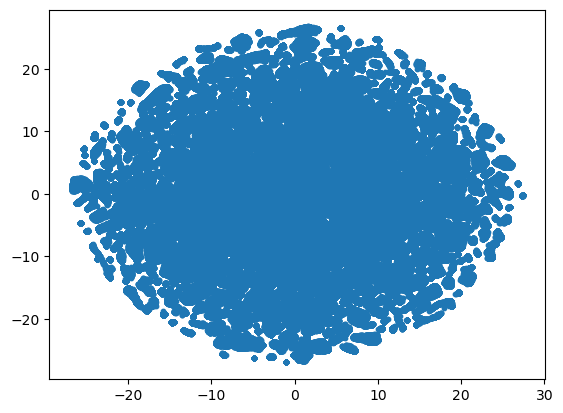

In [9]:
# Визуализируем полученные координаты точек двухмерного пространства
plt.scatter(df_all['X'], df_all['Y'], s=10);

## 4.2. Кластеризация методом К-средних

Расчитан шаг №1 для 2 кластеров.
Расчитан шаг №2 для 3 кластеров.
Расчитан шаг №3 для 4 кластеров.
Расчитан шаг №4 для 5 кластеров.
Расчитан шаг №5 для 6 кластеров.
Расчитан шаг №6 для 7 кластеров.
Расчитан шаг №7 для 8 кластеров.
Расчитан шаг №8 для 9 кластеров.
Расчитан шаг №9 для 10 кластеров.
Расчитан шаг №10 для 11 кластеров.


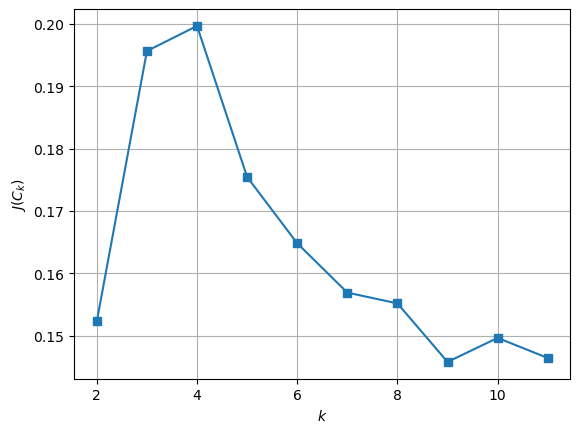

In [13]:
# Построим график оптимумов "колен" количесва кластеров
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
# Определим оптимального количества кластеров
inertia = []
silhouette = []
N = 12
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(df_num_cat_sc)
    preds = kmeans.predict(df_num_cat_sc)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_num_cat_sc, preds))
    print(f'Расчитан шаг №{k-1} для {k} кластеров.')

# Определим (графически) "колена", характеризующие оптимальное количесвто кластеров
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

Проверим визуально наиболее ярко выраженные участки графика (колени)

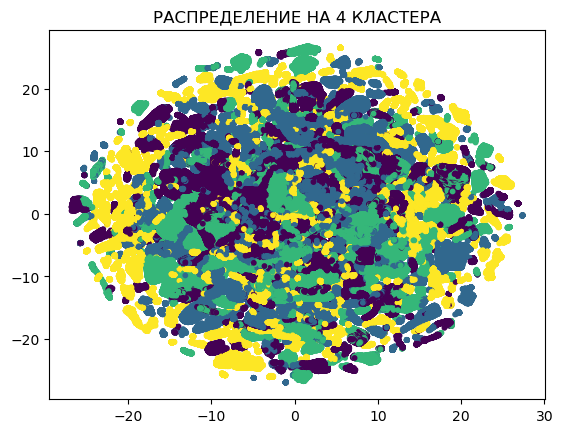

In [15]:
# Построим разбиение двухмерного пространства на 4 кластера
kmeans_4 = KMeans(n_clusters=4, n_init=10).fit(df_num_cat_sc)
plt.title('РАСПРЕДЕЛЕНИЕ НА 4 КЛАСТЕРА')
plt.scatter(df_all['X'], df_all['Y'], s=10, c=kmeans_4.labels_);

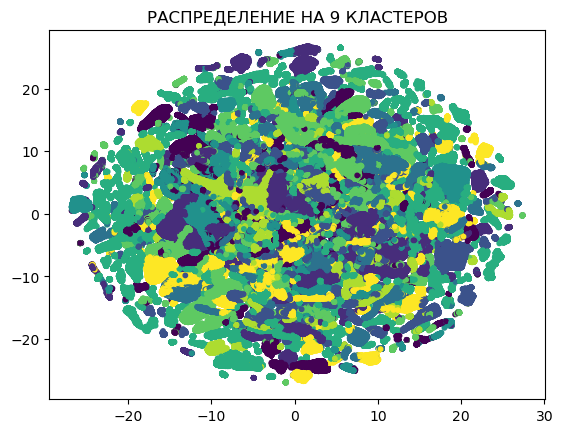

In [16]:
# Построим разбиение двухмерного пространства на 9 кластеров
kmeans_9 = KMeans(n_clusters=9, n_init=10).fit(df_num_cat_sc)
plt.title('РАСПРЕДЕЛЕНИЕ НА 9 КЛАСТЕРОВ')
plt.scatter(df_all['X'], df_all['Y'], s=10, c=kmeans_9.labels_);

**Выводы:** Визуально видно что при увеличении количества кластеров разделения покупателей на явные группы не улучшается. Кроме того при увеличении числа кластеров рвозрастает вероятность ошибочного отнесения точек пространства к кластерам. Таким образом целесообразно выбрать минималное количество кластеров представленное в оптимально выбранном списке "количества кластеров", то есть 4 кластера.

## 4.3. Определение основных признаков для группировки кластеров

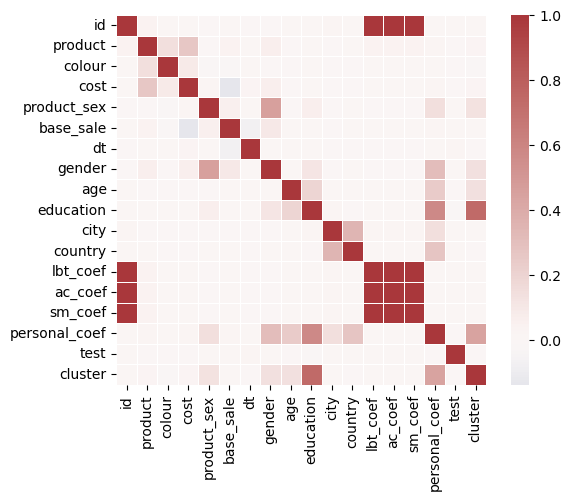

In [17]:
# Сформируем признаки кластеров для датасета
df_cluster = pd.DataFrame(data=kmeans_4.labels_, columns=['cluster'])
# Добавим признаки кластеров в датасет клииентов
df_cluster =df_all.join(df_cluster).drop(['X', 'Y'], axis=1)
# Выделим корреляцуии кластеров и иных признаков у покупок
corr_mat = df_cluster.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_mat, cmap='vlag', center=0, square=True, linewidths=.5)
plt.show()

In [18]:
# Выведем коэффициенты влияния отдельных признаков на отнесение покупок к кластерам 
corr_mat.cluster.sort_values(ascending=False)[1:]

education        0.738519
personal_coef    0.442814
gender           0.137130
age              0.136310
product_sex      0.129211
cost             0.027746
product          0.027114
city             0.014217
ac_coef          0.008823
lbt_coef         0.008493
sm_coef          0.008493
id               0.008493
base_sale        0.004031
dt              -0.000456
test            -0.007766
country         -0.010245
colour          -0.023227
Name: cluster, dtype: float64

**Вывод**: Разбиение на кластеры выявило признаки, по группе которых можно распределить клиентов таким образом что бы они проявляли одинаковые поведенческие патерны. Это значит что для повышения эффективности рекламных кампаний целесообразно делать их направленными на клиентов, с разными признаками: `education`, `personal_coef`, `gender`, `age`, `product_sex` - так как отличие именно этих прзнаков клиентов имеет сильную, среднюю и слабую корреляцию с разделением клиентов на кластеры.

## 4.4. Определение наиболее часто приобретаемых товаров в кластерах

In [19]:
# Выберем наиболее важные признаки при отнесении покупок к кластерам и получим датасет для клаччификации
importent_fit = list()
for name, value in zip(corr_mat, corr_mat.cluster):
    if value > 0.009: importent_fit.append(name)
importent_fit
df = df_cluster[importent_fit]
fit_columns = importent_fit[:-1]

In [20]:
# Функция многофакторной классификации датасета по признаку 'cluster'
def cluster_classifier(df, cluster):
    df = df_cluster[importent_fit] # Зададим исследуемый датасет
    # Выделим и закодируем категориальные признаки
    df_cat = df[df.columns[df.dtypes == 'object']]
    oe = OrdinalEncoder()
    df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
    # Масштабируем все признаки
    scaler = StandardScaler()
    df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
    df['cluster'] = df['cluster'].apply(lambda x: 1 if x == cluster else 0)
    rf = RandomForestClassifier()
    rf.fit(df[fit_columns], df['cluster'])
    fit_imp = dict()
    base_sale = 0
    for name, value in zip (fit_columns, rf.feature_importances_):
        if value > 0.009:
            fit_imp[name] = round(value, 6)
        if name == 'base_sale':
            base_sale = round(value, 6)
    str_1 = f'Признаки, по которым объединён кластер {cluster}, с важностью признака более 1%:\n'\
            f'{sorted(fit_imp.items(), key=lambda item: item[1], reverse=True)}\n' \
            f'Признак `base_sale` имеет существенность с долей: {base_sale}'
    return str_1

In [21]:
# Функция выявления 10 наиболее часто приобретаемых товаров в кластере
def choese_top(df):
    return df.groupby('product').agg({'id': 'count'}).id.sort_values(ascending=False)[:10]

# Выведим наиболее часто преобретаемые товары в каждом кластере
for elem in sorted(df_cluster.cluster.unique()):
    print(cluster_classifier(df, elem))
    print(f'Клиенты, отнесённые к кластеру {elem} '
          f' наиболее часто преобретают следующие товары:\n'
          f'{choese_top(df_cluster[df_cluster.cluster == elem])}\n')

/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/19836

Признаки, по которым объединён кластер 0, с важностью признака более 1%:
[('product', 0.393403), ('cost', 0.226707), ('age', 0.157966), ('city', 0.136804), ('education', 0.042333), ('product_sex', 0.019962), ('personal_coef', 0.018763)]
Признак `base_sale` имеет существенность с долей: 0
Клиенты, отнесённые к кластеру 0  наиболее часто преобретают следующие товары:
product
Лиф женский Joss                     2328
Плавки женские Joss                  1562
Футболка женская Demix               1442
Футболка мужская Demix               1378
Кресло кемпинговое Outventure        1133
Ветровка женская Outventure          1086
Брюки женские Outventure              884
Балетки женские Demix Ballerina 2     812
Футболка женская FILA                 784
Сабо Crocs Crocband                   742
Name: id, dtype: int64



/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/19836

Признаки, по которым объединён кластер 1, с важностью признака более 1%:
[('product', 0.605358), ('cost', 0.125969), ('age', 0.096099), ('education', 0.069049), ('city', 0.067916), ('personal_coef', 0.019089), ('product_sex', 0.012895)]
Признак `base_sale` имеет существенность с долей: 0
Клиенты, отнесённые к кластеру 1  наиболее часто преобретают следующие товары:
product
Брюки мужские Demix         3839
Брюки мужские Outventure    2012
Брюки мужские FILA          1958
Купальник женский Joss      1687
Брюки женские FILA          1477
Лиф женский Termit          1277
Легинсы женские Demix       1241
Брюки женские Demix         1220
Брюки женские Outventure    1217
Купальник женский FILA      1178
Name: id, dtype: int64



/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/19836

Признаки, по которым объединён кластер 2, с важностью признака более 1%:
[('product', 0.606876), ('cost', 0.112318), ('age', 0.10063), ('education', 0.082844), ('city', 0.067435), ('personal_coef', 0.014711), ('product_sex', 0.013682)]
Признак `base_sale` имеет существенность с долей: 0
Клиенты, отнесённые к кластеру 2  наиболее часто преобретают следующие товары:
product
Шорты мужские Demix                   3219
Футболка мужская Demix                1552
Рюкзак Demix                          1324
Сумка FILA                            1294
Футболка женская Demix                1286
Толстовка мужская Demix               1280
Шорты для мальчиков Demix             1211
Рюкзак FILA                           1150
Сандалии женские Skechers Arch Fit    1127
Солнцезащитные очки Kappa             1116
Name: id, dtype: int64



/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_29715/19836

Признаки, по которым объединён кластер 3, с важностью признака более 1%:
[('education', 0.530191), ('age', 0.308106), ('personal_coef', 0.14485), ('gender', 0.013632)]
Признак `base_sale` имеет существенность с долей: 0
Клиенты, отнесённые к кластеру 3  наиболее часто преобретают следующие товары:
product
Шорты мужские Demix         1004
Брюки мужские Demix          867
Футболка мужская Demix       714
Брюки мужские FILA           695
Сабо Crocs Crocband          552
Шорты мужские Nike           535
Футболка женская Demix       524
Брюки мужские Outventure     509
Брюки мужские Kappa          430
Футболка мужская Termit      423
Name: id, dtype: int64



**Выводы:**  
1) При определении каждого кластера клиентов важными являются признаки age, education, personal_coef. Это означает, что при разработке рекламных кампаний вместе с персональным коэффициентом целесообразно, в первую очередь, акцентировать внимание на конкретные возрастные группы. А учитывая рекомендации из раздела 3 настоящего отчёта — дополнительно стоит учитывать статистику доходов возрастных групп: 
 - Так клиентам от 31 до 61 года целесообразно предлагать наиболее дорогие и бОльшие по комплектации товары.
 - При достаточности ресурсов на рекламные кампании целесообразно разработать и провести отдельные кампании на каждую возрастную группу, определённую признаком доходности: менее 31 года, от 31 до 61 года, старше 61 года.
 - При недостаточности ресурсов на рекламные кампании целесообразно разработать и провести кампанию для группы клиентов с наибольшим доходом - от 41 до 51 года. Для повышения имеджа компании как социально направленной можно исключит верхний диапазон акции и провести её для всех клиентолв старше 41 года.  

2) Для клиентов из кластера 3 одним из важных признаков является `gender`. Соответственно целесообразно разработать отдельные рекламные компании для женщин и мужчин и провести их в разные периоджы времени, чтобы продавцы консультанты спавлялись с потоком покупателей и концентрировались на продажах более уского спектра товаров, что в свою очередь повысит качество предпродажных консульаций и соответственно повысит количество продаж.     
3) При контакте с клиентом целесобразно сразу определять кдастер, к кторому он относится и предлагать ему дополнительно приобрести перечень товаров из топ-10 товаров, наиболее часто преобретаемых клиентами соответсвующего кластера (см.выше для каждого кластера).  

## 4.5. Определение доли существенности скидки для клиентов каждого кластера

In [29]:
# Функция определения статистически значимой разницы в покупках при наличии скидки
def get_difference(df, option):
    df_test = df[(df.cluster == cluster) & (df.test == 1)].groupby('dt').agg({'cost': option})
    df_control = df[(df.cluster == cluster) & (df.test == 0)].groupby('dt').agg({'cost': option})
    test = SampleComparisonTest() # print_console_flag=True - флаг для вывода информации в консоль
    test.select_run_test(df_test['cost'], df_control['cost'])
    if test.select_run_test(df_test['cost'], df_control['cost'])['Результат']['p-value'] < 0.05:
        print(f'В кластере {cluster} скидка влияет на покупки')
        fig, ax = plt.subplots(figsize=(12, 3))
        if option == 'sum':
            elem_1, elem_2 = 'СТОИМОСТИ', 'руб.'
        else:
            elem_1, elem_2 = 'ЧАСТОТЫ', 'шт.'
        ax.set_title(f'РАСПРЕДЕЛЕНИЕ {elem_1} ПОКУПОК ПО ДНЯМ ПЕРВОЙ РЕКЛАМНОЙ КАМПАНИИ')
        ax.set_ylabel(f'Покупки, {elem_2}')
        ax.set_xlabel('Дни покупки')
        ax.bar(df_test.index, df_test['cost'], width=0.3, color='green', label='Тестовая группа')
        ax.bar(df_control.index+0.4, df_control['cost'], width=0.6, color='gray', label='Контрольная группа')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        plt.legend();

В кластере 0 скидка влияет на покупки


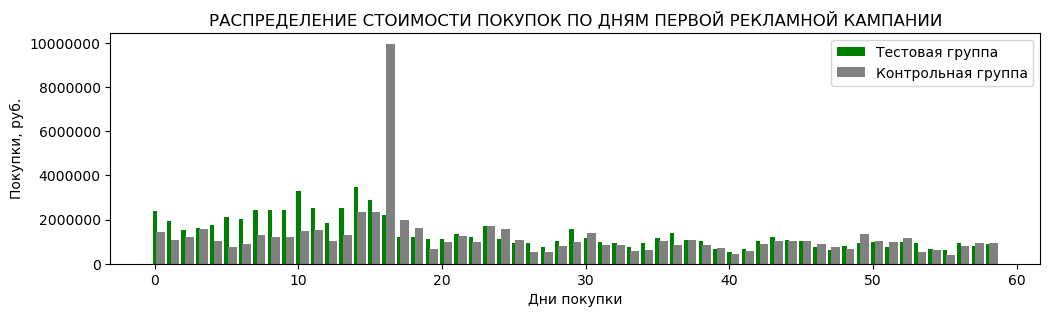

In [30]:
# Определим в каких кластерах скидка влияет на сумму покупок
for cluster in df.cluster.unique():
    get_difference(df_cluster[df_cluster.cluster == cluster], 'sum')

В кластере 0 скидка влияет на покупки
В кластере 2 скидка влияет на покупки
В кластере 3 скидка влияет на покупки


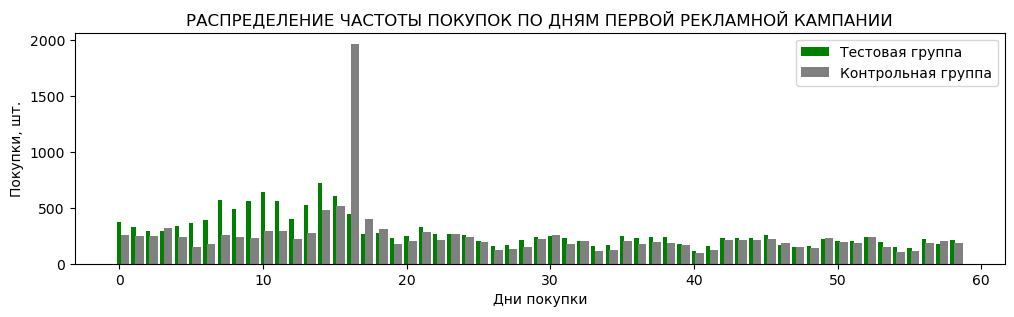

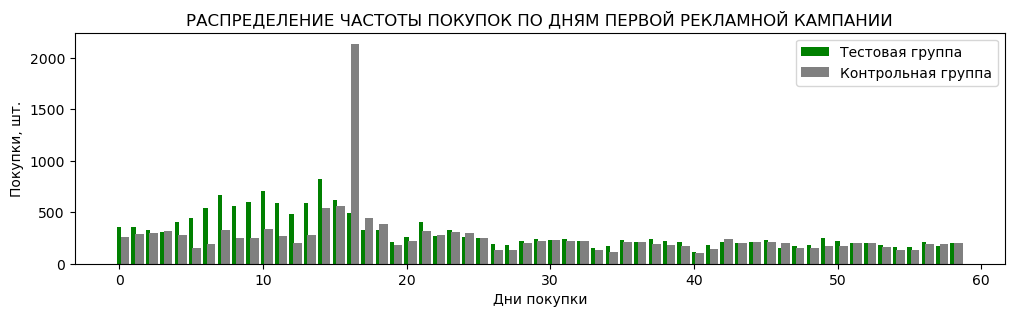

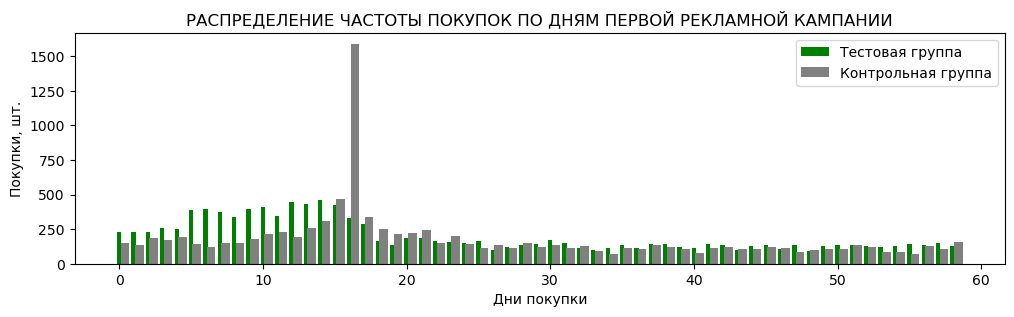

In [31]:
# Определим в каких кластерах скидка влияет на сумму частоту покупок
for cluster in df.cluster.unique():
    get_difference(df_cluster[df_cluster.cluster == cluster], 'count')

**Вывод**: при предоставлении скидки покупки статистически значимо увеличиваются:  
1) По сумме покупок - для клиентов кластера 0.  
2) По количеству покупок - для клиентов кластеров 0, 2 и 3.  
  
Таким образом среди клиентов вышеуказанных кластеров целесообразно проводить рекламные кампании, включающие в себя такую опцию как скидка.